In [ ]:
#| default_exp vlm.col_pali_qwenv2

In [ ]:
#| export
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
import torch
from fastcore.imports import *
from cv_tools.imports import *	

In [ ]:
from huggingface_hub import notebook_login

notebook_login()
     

In [ ]:
#| export
from pdf2image import convert_from_path

In [ ]:
#| export
from byaldi import RAGMultiModalModel

RAG = RAGMultiModalModel.from_pretrained(
    "vidore/colpali")

2024-09-08 12:14:27.154076: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-08 12:14:27.154126: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-08 12:14:27.154143: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-08 12:14:27.345442: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
No CUDA runtime is found, using 

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


/home/user/miniconda3/lib/python3.11/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


adapter_config.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/66.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/862M [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/78.6M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/243k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/733 [00:00<?, ?B/s]

In [ ]:
#images = convert_from_path(
    #"/content/climate_youth_magazine.pdf")
HOME = os.getenv("HOME")
print(HOME)
pdf_fn = f"{HOME}/Downloads/xception.pdf"
images = convert_from_path(pdf_fn)

/home/user


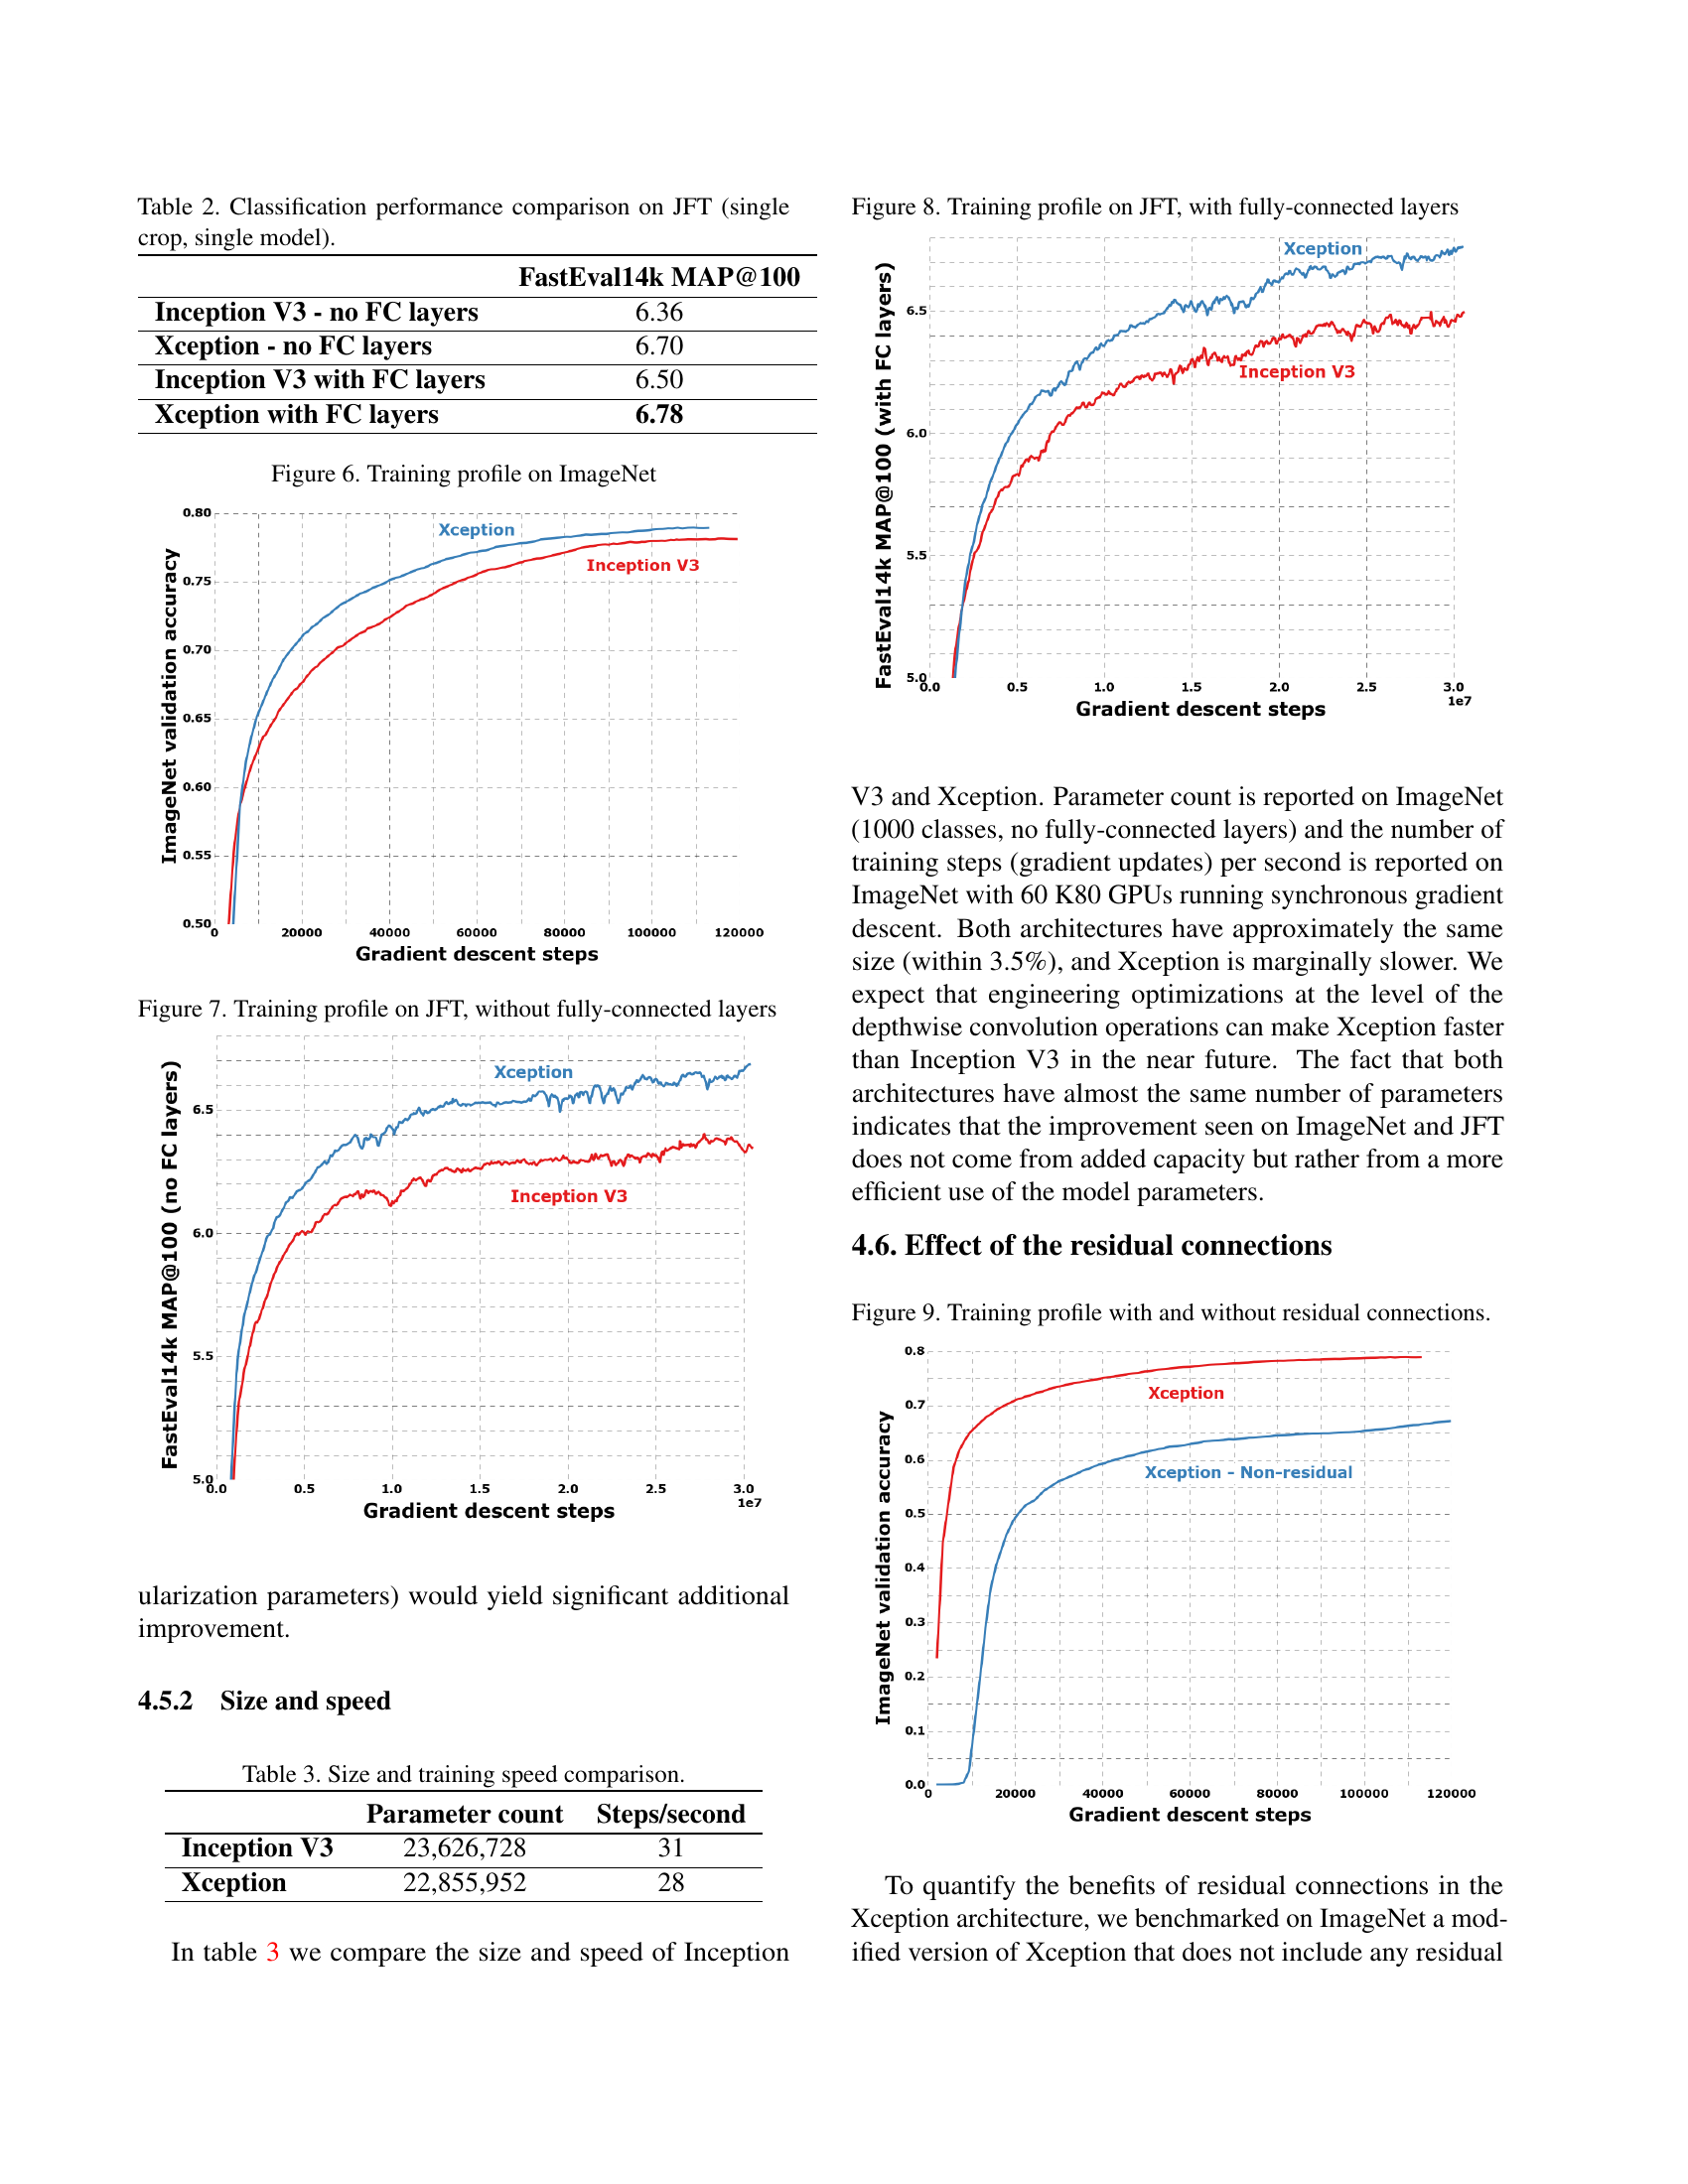

In [ ]:

images[5]

In [ ]:
RAG.index(
    input_path=pdf_fn,
    index_name="image_index", # index will be saved at index_root/index_name/
    store_collection_with_index=False,
    overwrite=True
)
   

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


Added page 1 of document 0 to index.
Added page 2 of document 0 to index.


In [ ]:
#text_query = "How much did the world temperature change so far?"
text_query = "How many parameters does InceptionV3 have?"
results = RAG.search(text_query, k=1)
results

In [ ]:
model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct",
	trust_remote_code=True, 
    torch_dtype=torch.bfloat16
    ).cuda().eval()
     

In [ ]:
processor = AutoProcessor.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct", 
    trust_remote_code=True
    )
image_index = results[0]["page_num"] - 1
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": images[image_index],
            },
            {"type": "text", "text": text_query},
        ],
    }
]

In [ ]:
text = processor.apply_chat_template(
    messages, 
    tokenize=False, 
    add_generation_prompt=True
)

In [ ]:
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")
     

In [ ]:
generated_ids = model.generate(**inputs, max_new_tokens=50)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)

In [ ]:
print(output_text)